# <center>**Trabajo Práctico Final**</center>

### <center>**Predicción de accidentes cerebrovasculares**</center>

#### <center>Aprendizaje de máquina - CEIA, Fiuba</center>

---

**Integrantes del grupo**

- Espínola, Carla
- Gambarte, Antonella
- Putrino, Daniela
- Silvera, Ricardo

---


## **Presentación**

El siguiente proyecto tiene como finalidad realizar un análisis comparativo de distintos modelos con el fin de predecir si una persona puede tener un acv o no. Para ello usaremos el Stroke Prediction Dataset disponible en Kaggle.

Link al dataset: [https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

Se abordará el análisis exploratorio de los datos, su preprocesamiento y preparación, el empleo de distintos modelos para la predicción y la evaluación de los resultados obtenidos.


## **Análisis Exploratorio de Datos**


### Bibliotecas

In [137]:
#!pip install pandas matplotlib seaborn scikit-learn numPy 
#!pip install imblearn
#!pip install optuna
#!pip install --force-reinstall xgboost

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from optuna.pruners import MedianPruner
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


In [2]:
import warnings
warnings.filterwarnings('ignore')

### Carga de dataset


In [3]:
df_stroke = pd.read_csv("dataset/healthcare-dataset-stroke-data.csv")
df_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Cantidad de variables y observaciones


In [4]:
filas,columnas = df_stroke.shape
print(f"El DataFrame tiene {filas} observaciones y {columnas} variables.")

El DataFrame tiene 5110 observaciones y 12 variables.


In [5]:
df_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Primero eliminamos la columna id por tratarse de un identificador único que no aporta valor predictivo ni analítico.


In [6]:
df_stroke = df_stroke.drop(columns=['id'])

### Analizamos si hay duplicados y nulos


In [7]:
print("Cantidad de datos duplicados:", df_stroke.duplicated().sum())

Cantidad de datos duplicados: 0


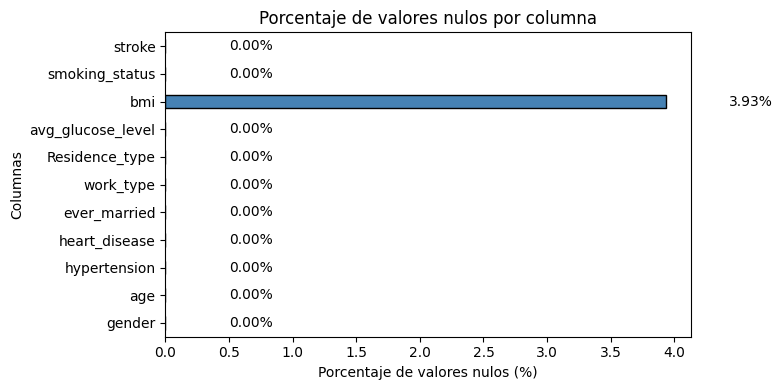

In [8]:
porcentaje_nulos = df_stroke.isna().mean().round(4) * 100

plt.figure(figsize=(8, 4))
porcentaje_nulos.plot(kind='barh', color='steelblue',edgecolor='black')

plt.title('Porcentaje de valores nulos por columna')
plt.xlabel('Porcentaje de valores nulos (%)')
plt.ylabel('Columnas')

for index, value in enumerate(porcentaje_nulos):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.tight_layout()
plt.show()

Como se observa, la única variable con valores nulos es la de bmi.

Vamos a hacer una comparativa de los faltantes respecto a distintos grupos etarios. Esta información nos va a servir en la etapa de preprocesamiento y preparación de datos para elegir el tratamientos adecuado.


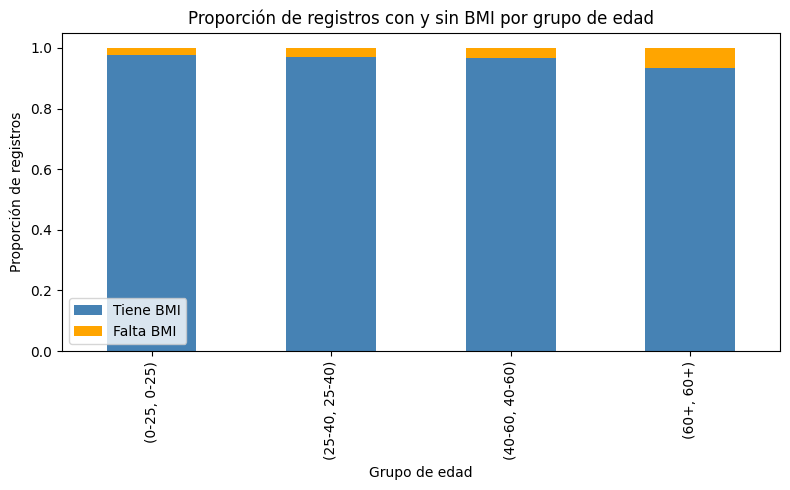

In [9]:
df_temp = df_stroke.copy()
df_temp["bmi_missing"] = df_temp["bmi"].isnull()

# Grupos de edad
bins = [0, 25, 40, 60, df_stroke["age"].max() + 1]
labels = ["0-25", "25-40", "40-60", "60+"]
df_temp["age_group"] = pd.cut(df_temp["age"], bins=bins, labels=labels, right=False)

# Calculamos proporciones dentro de cada grupo
prop_by_group = (
    df_temp.groupby(["age_group", "bmi_missing"], observed=True)
    .size()
    .groupby(level=0, observed=True)
    .apply(lambda x: x / x.sum())
    .unstack()
)

# Gráfico de barras apiladas
prop_by_group.plot(kind="bar", stacked=True, figsize=(8,5), color=["steelblue", "orange"])
plt.ylabel("Proporción de registros")
plt.xlabel("Grupo de edad")
plt.title("Proporción de registros con y sin BMI por grupo de edad")
plt.legend(["Tiene BMI", "Falta BMI"])
plt.tight_layout()
plt.show()

Observamos que los datos faltantes de BMI aumentan con la edad, por lo que se deduce que exite una dependencia de los faltantes con la edad.


### Estadísticas


In [10]:
df_stroke.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Para hypertension, heart_disease y el target stroke, se observa un desbalanceo. Analizaremos mirando los histogramas.


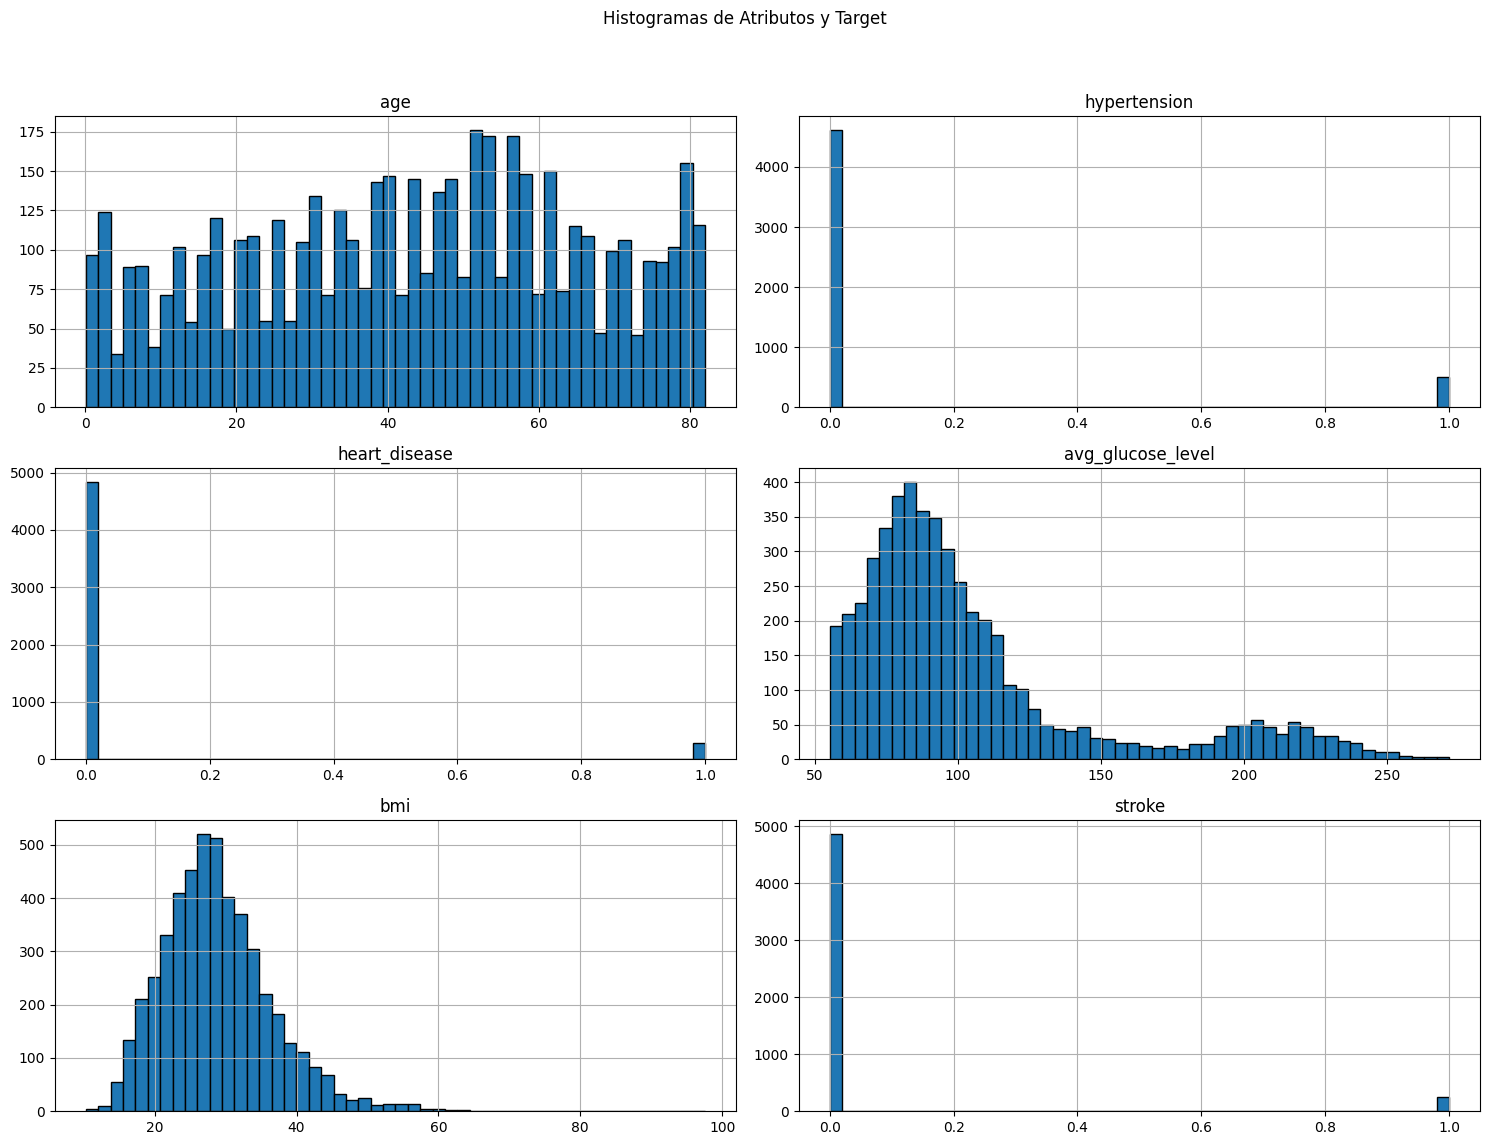

In [11]:
df_stroke.hist(figsize=(15, 12), bins=50, edgecolor='black')
plt.suptitle('Histogramas de Atributos y Target')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Claramente hypertension, heart_disease y el target stroke se encuentran muy desbalanceadas. En cuanto a avg_glucose_level tiene una distribución asimétrica positiva y BMI tiene una distribución más simétrica, con forma de campana (aproximadamente normal).

Vamos a analizar los valores altos que tienen bmi y avg_glucose_level para saber si contiene outliers o no.


{'avg_glucose_level': 627, 'bmi': 110}

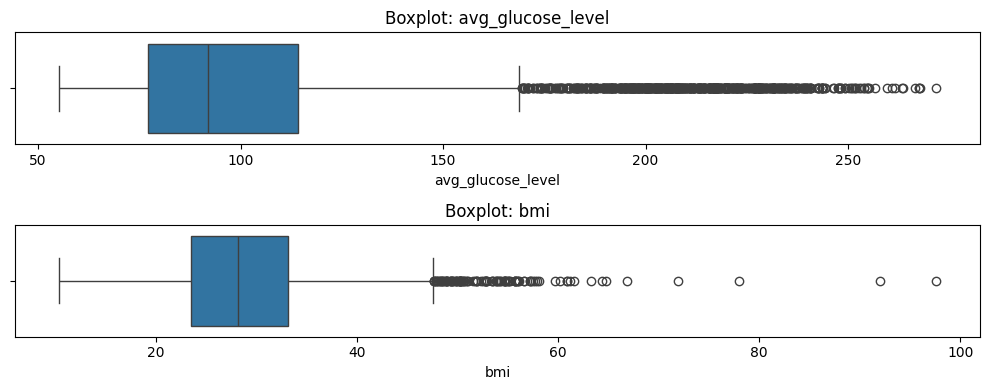

In [12]:
num_cols= ['avg_glucose_level','bmi']
outlier_summary = {}
plt.figure(figsize=(10, len(num_cols)*2))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.boxplot(x=df_stroke[col])
    plt.title(f'Boxplot: {col}')
    q1 = df_stroke[col].quantile(0.25)
    q3 = df_stroke[col].quantile(0.75)
    iqr = q3 - q1
    lb = q1 - 1.5*iqr
    ub = q3 + 1.5*iqr
    outlier_summary[col] = int(((df_stroke[col] < lb) | (df_stroke[col] > ub)).sum())
plt.tight_layout()
outlier_summary

A primera vista existen muchos outliers. Vamos a hacer una comparativa de esas varibles con el target stroke, para saber si existe una relación entre los valores altos de glucosa y masa corporal con las personas que tuvieron acv.


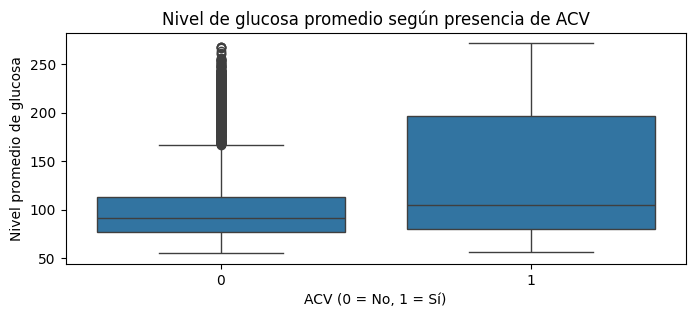

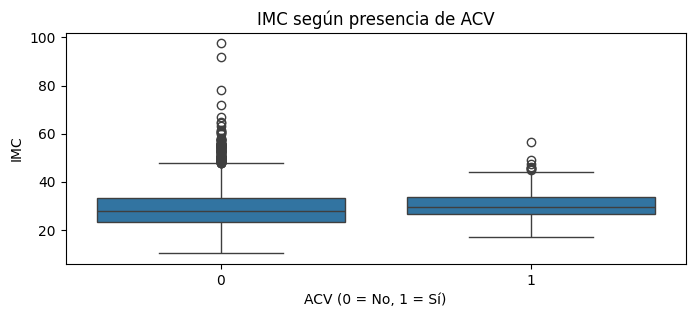

In [13]:
# Boxplot para glucosa
plt.figure(figsize=(8, 3))
sns.boxplot(data=df_stroke, x='stroke', y='avg_glucose_level')
plt.title('Nivel de glucosa promedio según presencia de ACV')
plt.xlabel('ACV (0 = No, 1 = Sí)')
plt.ylabel('Nivel promedio de glucosa')
plt.show()

# Boxplot para BMI
plt.figure(figsize=(8, 3))
sns.boxplot(data=df_stroke, x='stroke', y='bmi')
plt.title('IMC según presencia de ACV')
plt.xlabel('ACV (0 = No, 1 = Sí)')
plt.ylabel('IMC')
plt.show()

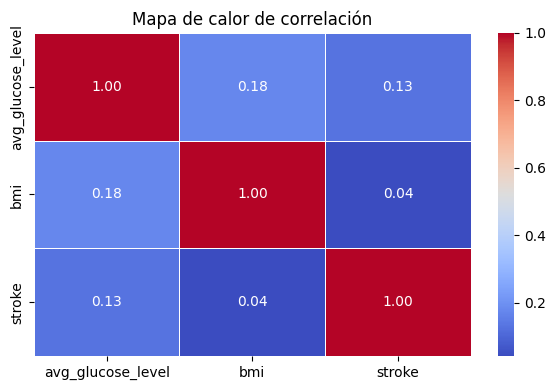

In [14]:
corr_matrix = df_stroke[['avg_glucose_level', 'bmi', 'stroke']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de calor de correlación')
plt.tight_layout()
plt.show()


Observando los gráficos anteriores vemos que el nivel de glucosa alto es la variable más relacionada con stroke, aunque su correlación es baja.
BMI apenas se relaciona con stroke.


Ahora empleamos la matriz de correlación para analizar las posibles relaciones entre las distintas varibles numéricas.


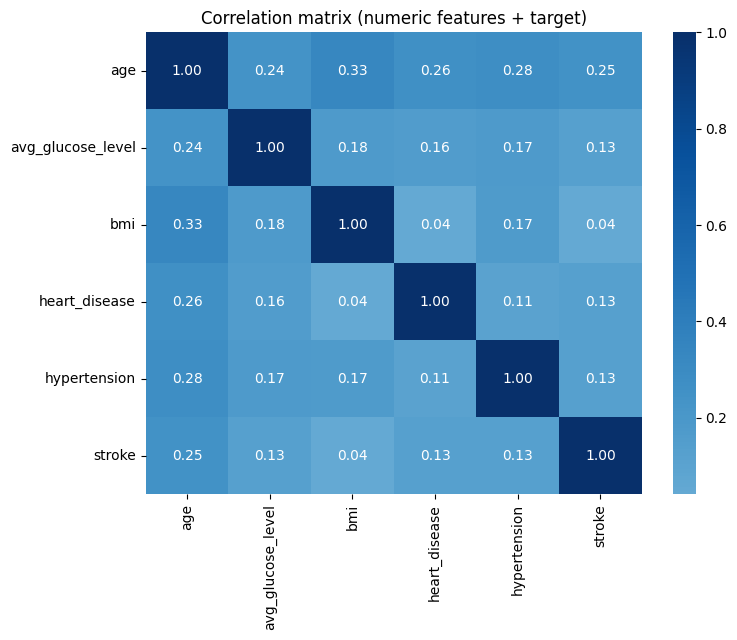

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
Name: stroke, dtype: float64

In [15]:
num_cols = df_stroke.select_dtypes(include=['number']).columns.drop('stroke')
corr = df_stroke[num_cols.union(['stroke'])].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap=sns.color_palette("Blues", as_cmap=True), center=0)
plt.title('Correlation matrix (numeric features + target)')
plt.show()

corr_with_target = corr['stroke'].sort_values(ascending=False)
corr_with_target

Vemos que la edad es factor más relacionado con la presencia de ACV, seguido por niveles de glucosa promedio, hipertensión y enfermedad cardíaca, aunque todas con correlaciones débiles. Por el contrario, el IMC no muestra una relación significativa con el ACV en esta muestra.

En términos generales, las variables numéricas no presentan alta colinealidad entre sí, lo que sugiere que pueden aportar información independiente en modelos predictivos.


### Análsis de variables categóricas


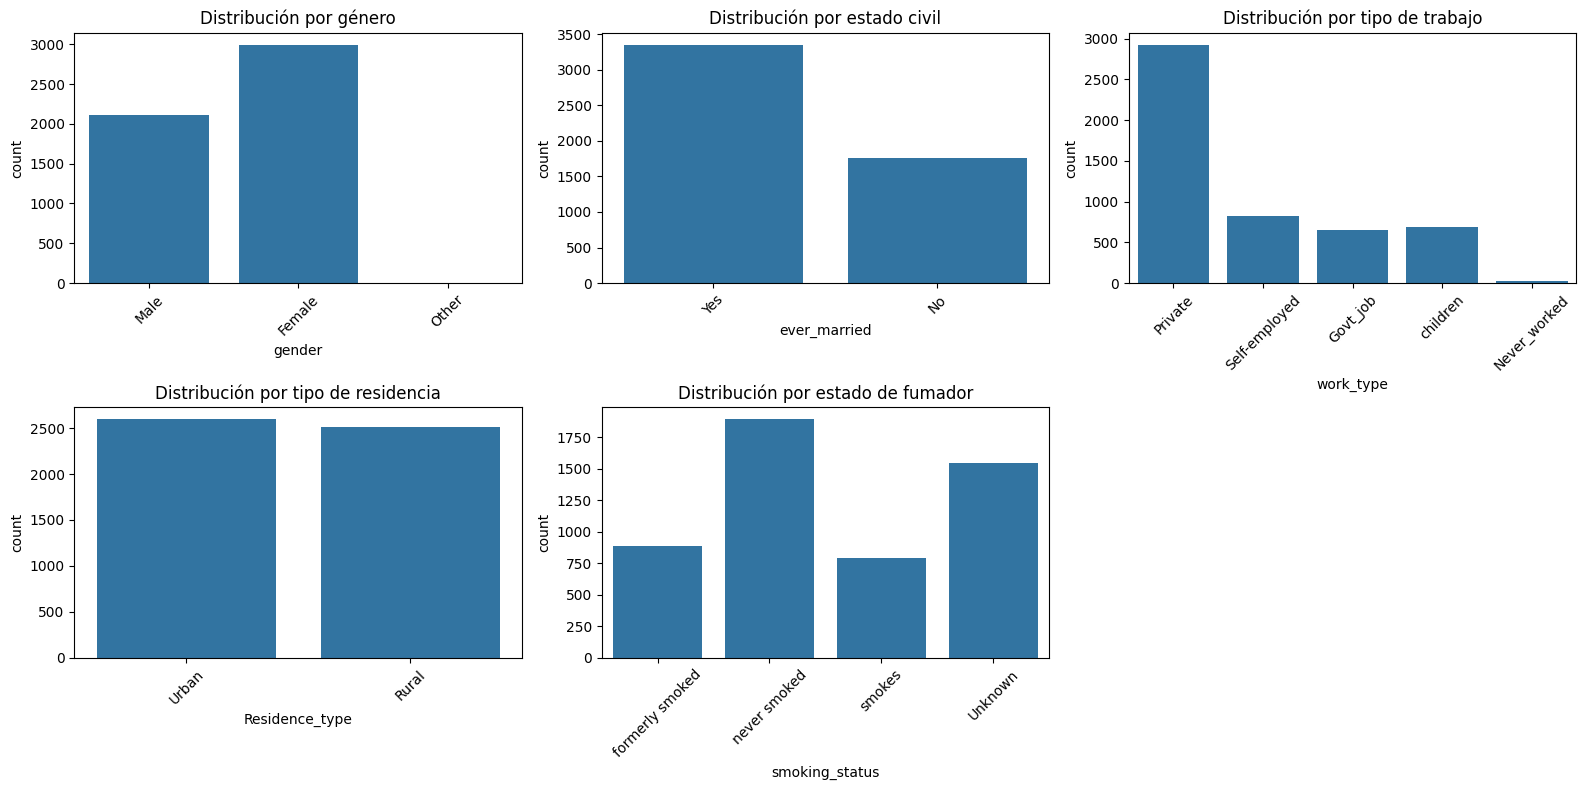

In [16]:
# Lista de columnas
cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
titles = ['Distribución por género', 'Distribución por estado civil', 'Distribución por tipo de trabajo', 
          'Distribución por tipo de residencia', 'Distribución por estado de fumador']

fig, axes = plt.subplots(2, 3, figsize=(16, 8))  
axes = axes.flatten()

for i, (col, title) in enumerate(zip(cols, titles)):
    sns.countplot(data=df_stroke, x=col, ax=axes[i])
    axes[i].set_title(title)
    axes[i].tick_params(axis='x', rotation=45)

if len(cols) < len(axes):
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Observaciones relevantes:

- Para género, existe una categoría "Other" que esta presente en una proporción pequeña.
- Para tipo de trabajo, también existe una categoría "Never worked" que esta presente en una pequeña proporción.
- En cuanto al estado civil, exite una desbalance, pero que consideramos aceptable.
- Para el estado del fumador, existe una categoría "Unknown" que, dado que tiene una cantidad considerable de datos si comparamos con las demás. Vamos a tratarla como una categoría más.


## **Preprocesamiento y Preparación de Datos**

Como primer paso, dividimos el dataset en train y test a fin de evitar el data leakage


In [37]:
X = df_stroke.drop("stroke", axis=1)
y = df_stroke["stroke"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Tratamiento de nulos

Dado que los faltantes en BMI representan sólo el 3.93% y como resultado del análisis de faltantes con respecto a la edad, decimos imputar los faltantes con la mediana por grupo de edad.


In [39]:
# Definimos grupos de edad
bins = [0, 25, 40, 60, df_stroke["age"].max() + 1]
labels = ["0–25", "25–40", "40–60", "60+"]

X_train["age_group"] = pd.cut(X_train["age"], bins=bins, labels=labels, right=False)
X_test["age_group"] = pd.cut(X_test["age"], bins=bins, labels=labels, right=False)

# Calculamos mediana de bmi por grupo solo en train
group_medians = X_train.groupby("age_group", observed=True)["bmi"].median()

# Función para imputar usando las medianas del train
def imputar_bmi(row):
    if pd.isnull(row["bmi"]):
        return group_medians.get(row["age_group"], X_train["bmi"].median())
    else:
        return row["bmi"]

# Aplicamos en train y test
X_train["bmi"] = X_train.apply(imputar_bmi, axis=1)
X_test["bmi"] = X_test.apply(imputar_bmi, axis=1)


X_train.drop(columns="age_group", inplace=True)
X_test.drop(columns="age_group", inplace=True)


### Outliers

Para BMI vamos a hacer una trasformación logarítmica para disminuir el impacto de los outliers.


In [40]:
X_train['bmi'] = np.log1p(X_train['bmi'])
X_test['bmi'] = np.log1p(X_test['bmi'])

PREGUNTA: Faltaría el nivel de glucosa. No se que sugieren que hagamos con eso. O se lo ve cuando hagamos los modelos.


### Variables categoricas

- Gender: Contamos cuantos hay por cada categoría.


In [41]:
df_stroke['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Como existe solo una fila con género "Other", decidimos fusionarlo con la categoría "Female" que es la que tiene más presencia y así minimizamos el impacto en la dispersión de datos.


In [42]:
print(X_train['gender'].value_counts())
print(X_test['gender'].value_counts())


gender
Female    2395
Male      1692
Other        1
Name: count, dtype: int64
gender
Female    599
Male      423
Name: count, dtype: int64


In [43]:
X_train['gender'] = X_train['gender'].replace('Other', 'Female')

Para codificar los datos usamos One-Hot Encoding


In [44]:
encoder = OneHotEncoder(sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[['gender']])
X_test_encoded = encoder.transform(X_test[['gender']])

encoded_cols = encoder.get_feature_names_out(['gender'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

X_train = X_train.drop(columns=['gender']).join(X_train_encoded_df)
X_test = X_test.drop(columns=['gender']).join(X_test_encoded_df)


- Residence_type: aplicamos One-Hot Encoding


In [45]:

encoder_res = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_res = encoder_res.fit_transform(X_train[['Residence_type']])
X_test_encoded_res = encoder_res.transform(X_test[['Residence_type']])

encoded_cols_res = encoder_res.get_feature_names_out(['Residence_type'])
X_train_encoded_res_df = pd.DataFrame(X_train_encoded_res, columns=encoded_cols_res, index=X_train.index)
X_test_encoded_res_df = pd.DataFrame(X_test_encoded_res, columns=encoded_cols_res, index=X_test.index)

X_train = X_train.drop(columns=['Residence_type']).join(X_train_encoded_res_df)
X_test = X_test.drop(columns=['Residence_type']).join(X_test_encoded_res_df)


- ever_married: codificación manual donde Yes=1 y No=0


In [46]:
X_train['ever_married'] = X_train['ever_married'].map({'No': 0, 'Yes': 1})
X_test['ever_married'] = X_test['ever_married'].map({'No': 0, 'Yes': 1})

- smoking_status

PREGUNTA: Dejamos las 4?. o agrupamos "formerly smoked" y "smokes" por un lado y "never smoked" y "Unknown" por otro?. Mas que nada por la cantidad de columna que se generan


In [47]:
X_train['smoking_status']

845        never smoked
3744       never smoked
4183       never smoked
3409             smokes
284             Unknown
             ...       
1434    formerly smoked
461             Unknown
1052    formerly smoked
1757            Unknown
5052            Unknown
Name: smoking_status, Length: 4088, dtype: object

In [48]:
encoder_smoke = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_smoke = encoder_smoke.fit_transform(X_train[['smoking_status']])
X_test_encoded_smoke = encoder_smoke.transform(X_test[['smoking_status']])

encoded_cols_smoke = encoder_smoke.get_feature_names_out(['smoking_status'])
X_train_encoded_smoke_df = pd.DataFrame(X_train_encoded_smoke, columns=encoded_cols_smoke, index=X_train.index)
X_test_encoded_smoke_df = pd.DataFrame(X_test_encoded_smoke, columns=encoded_cols_smoke, index=X_test.index)


X_train = X_train.drop(columns=['smoking_status']).join(X_train_encoded_smoke_df)
X_test = X_test.drop(columns=['smoking_status']).join(X_test_encoded_smoke_df)


- work_type: analizamos primero la cantidad de "Never_worked"


In [49]:
count_never_worked_train = (X_train['work_type'] == 'Never_worked').sum()
count_never_worked_test = (X_test['work_type'] == 'Never_worked').sum()

print(f"Never_worked en train: {count_never_worked_train}")
print(f"Never_worked en test: {count_never_worked_test}")


Never_worked en train: 13
Never_worked en test: 9


PREGUNTA: No se que les parece hacer esto a continuación?

No exiten muchos presentes. Optamos por unirlos a la categoría "Children" ya que esta es una categoría que indica que no trabaja activamente.


In [50]:
X_train['work_type'] = X_train['work_type'].replace('Never_worked', 'Children')
X_test['work_type'] = X_test['work_type'].replace('Never_worked', 'Children')

In [51]:
encoder_work = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

X_train_encoded_work = encoder_work.fit_transform(X_train[['work_type']])
X_test_encoded_work = encoder_work.transform(X_test[['work_type']])


encoded_cols_work = encoder_work.get_feature_names_out(['work_type'])
X_train_encoded_work_df = pd.DataFrame(X_train_encoded_work, columns=encoded_cols_work, index=X_train.index)
X_test_encoded_work_df = pd.DataFrame(X_test_encoded_work, columns=encoded_cols_work, index=X_test.index)


X_train = X_train.drop(columns=['work_type']).join(X_train_encoded_work_df)
X_test = X_test.drop(columns=['work_type']).join(X_test_encoded_work_df)


In [52]:
X_train.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Female,gender_Male,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,work_type_Children,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children
845,48.0,0,0,1,69.21,3.529297,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3744,15.0,0,0,0,122.25,3.091042,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4183,67.0,0,0,1,110.42,3.254243,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3409,44.0,0,0,1,65.41,3.250374,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
284,14.0,0,0,0,82.34,3.484312,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Escalado de datos

In [53]:
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train)
X_test_scaled = sc_X.transform(X_test)

### Oversampling con SMOTE para pruebas de balanceo

In [54]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [55]:
X_train_ovs, y_train_ovs = smote.fit_resample(X_train, y_train)

In [58]:
print(X_train.shape)
print(X_train_scaled.shape)
print(X_train_res.shape)
print(X_train_ovs.shape)


(4088, 19)
(4088, 19)
(7778, 19)
(7778, 19)


## **Modelización**


### Funciones necesarias

In [59]:
def plot_roc_curve(y_test, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def champion_callback(study, frozen_trial):
    """
    Mostramos menos información, sino es demasiado verboso
    """
    winner = study.user_attrs.get("winner", None)
    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

def plot_confusion_matrix(y_test, y_pred, model_name):
    matriz = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Clasificación')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.show()



def mostrar_resultados(y_test, y_pred,model_name):
    """
    Muestra en 3 columnas:
    1) Reporte de clasificación
    2) Matriz de confusión
    3) Curva ROC (solo si se pasan probabilidades y el problema es binario)

    Parámetros:
        y_test : etiquetas reales
        y_pred : etiquetas predichas
        X_train: datos de entrenamiento (para obtener las clases)
        y_prob : probabilidades predichas (predict_proba) -> opcional
    """
    # Obtener clases únicas desde el entrenamiento
    clases = sorted(set(y_test) | set(y_pred))



    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    print('Accuracy General:',accuracy)

    # Reporte de clasificación ---
    reporte = classification_report(y_test, y_pred, target_names=[str(c) for c in clases], output_dict=True)
    sns.heatmap(
        pd.DataFrame(reporte).iloc[:-1, :].T,
        annot=True, cmap="Blues", fmt=".2f", ax=axes[0]
    )
    axes[0].set_title(f'Reporte de Clasificación - {model_name}')

    # Matriz de confusión ---
    cm = confusion_matrix(y_test, y_pred, labels=clases)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=clases, yticklabels=clases, ax=axes[1])
    axes[1].set_xlabel("Predicción")
    axes[1].set_ylabel("Real")
    axes[1].set_title(f'Matriz de Confusión - {model_name}')

   
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    axes[2].plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title(f'Receiver Operating Characteristic - {model_name}')
    axes[2].legend(loc='lower right')
    plt.grid()
    plt.show()


### Árbol de Clasificación

Implementamos un modelo de Árbol de Clasificación, sabiendo a priori que este modelo no es recomendable cuando los datos de entrada están desbalanceados, como es nuestro caso, pero el motivo de esta decisión fue con fines experimentales que permitan comprobar en la práctica el comportamiento de este modelo en la situación planteada.

Desarrollamos una implementación desde cero, sin usar librerías que implementen el modelo, para ello definimos dos clases:

1) **Nodo**: Es el núcleo fundamental de este algoritmo y el que constituye la estructura básica del árbol de clasificación. Cada nodo puede ser:

- Un nodo de decisión (con feature, threshold, y nodos hijos left/right)

- Un nodo hoja (con value que representa la clase predicha)



2) **ArbolClasificacion**: Contiene la lógica codificada para la construcción del árbol de clasificación en base a los datos de entrada y los parámetros (entrenamiento) y metodos auxilizares para esta construcción y recuperación de la una predicción. Esta clase consiste en los siguientes métodos:
- init : El constructor de la clase, permite instanciar un árbol de clasificación y establecer los hiperparámetros:
    - max_depth: profundidad máxima del árbol

    - min_samples_split: número mínimo de muestras requeridas para dividir un nodo

    - criterio: métrica para evaluar la calidad de las divisiones (‘gini’ o ‘entropia’)
    
    - _gini/_entropia: Implementaciones de las métricas para evaluar las divisiones
    
    -  _best_split: Encuentra la mejor división posible para un nodo evaluando todos los posibles puntos de corte
    
    - _build_tree: Construye recursivamente el árbol hasta alcanzar las condiciones de parada
    
    - fit: Entrena el modelo con los datos de entrada y los targets
    
    - predict: Realiza predicciones para nuevas muestras
    
    - metricas (estático): Proporciona evaluación del modelo mediante:
        - Accuracy score
        - Matriz de confusión 
        - Reporte de clasificación 


Tambien incluimos condiciones de parada parametrizables:
- Alcanzar una profundidad máxima
- Tener menos muestras que min_samples_split


Este enfoque nos permite comprender en profundidad el funcionamiento interno de los árboles de decisión, sus ventajas y limitaciones, particularmente en escenarios con datos desbalanceados.


In [60]:

class Nodo:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class ArbolClasificacion:
    def __init__(self, max_depth=3, min_samples_split=100, criterio='gini'):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        if criterio not in ['gini', 'entropia']:
            raise ValueError("El criterio debe ser 'gini' o 'entropia'")
        self.criterio = criterio
        self.root = None

    def _gini(self, y):
        """
        Calcula el índice de Gini con los valores de y
        Args:
            y : valores sobre lso que se calcula el índice .
        
        """
        clases = np.unique(y)
        impurity = 1.0
        for c in clases:
            p = np.sum(y == c) / len(y)
            impurity -= p ** 2
        return impurity

    def _entropia(self, y):
        """
        Calcula el valor de la entropía de los datos en y

        Args:
            y: valores de sobre los que se calcula la entropía .
        """
        clases, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probs if p > 0])

    def _gain(self, y):
        if self.criterio == 'gini':
            return self._gini(y)
        else:
            return self._entropia(y)

    def _best_split(self, X, y):
        """
        Busca la mejor división posible de los datos en un nodo.

        Args:
            X: datos de entrada.
            y: etiquetas correspondientes.

        Returns:
            best_idx: índice de la feature que produce la mejor división.
            best_thr: valor umbral para esa feature.
        """
        best_score = np.inf if self.criterio == 'entropia' else 1
        best_idx, best_thr = None, None
        n_samples, n_features = X.shape
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                y_left = y[X[:, feature] <= t]
                y_right = y[X[:, feature] > t]
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                score = (len(y_left) * self._gain(y_left) + len(y_right) * self._gain(y_right)) / n_samples
                if (self.criterio == 'gini' and score < best_score) or (self.criterio == 'entropia' and score < best_score):
                    best_score = score
                    best_idx = feature
                    best_thr = t
        return best_idx, best_thr

    def _build_tree(self, X, y, depth):
        """
        Construye el arbol de clasificación

        Args:
            X: valores de feactures.
            y: valores de las etiquetas.
            depth: Profundidad máxiam del arbol.
        """
        
        #Condicion de parada: si todas las etiquetas son iguales o se cumple con la altura máxima o no se cumple con la cantidad minima de elementos
        if len(set(y)) == 1 or depth >= self.max_depth or len(y) < self.min_samples_split:
            value = np.bincount(y).argmax()
            return Nodo(value=value)
        #Realizar la mejor separación de los datos, se otiene el indice y el valor umbral para separar
        feature, threshold = self._best_split(X, y)

        # Si no se pudo separar
        if feature is None:
            value = np.bincount(y).argmax()
            return Nodo(value=value)
        
        idx_left = X[:, feature] <= threshold
        #llamado recursivo con los valores de de la rama izquierda
        left = self._build_tree(X[idx_left], y[idx_left], depth + 1)
        #llamado recursivo con los valores de de la rama derecha
        right = self._build_tree(X[~idx_left], y[~idx_left], depth + 1)
        return Nodo(feature, threshold, left, right)

    def fit(self, X, y):
        """
        Entrena el modelo

        Args:
            X: valores de feactures de entrenamiento.
            y: valores de las etiquetas de entrenamiento.
        """
        self.root = self._build_tree(np.array(X), np.array(y), 0)

    def _predict_one(self, x, node):
        """
        Realiza la clasificación para una muestra
        
        Args:
            x: valores de feactures de una muestra.
            nodo: nodo del arbol para navegar hasta la solución.
        """
        if node.value is not None:
            return node.value
        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        """
        Realiza la predicción para los datos en X
        
        Args:
            X: valores de feactures para clasificar.
            nodo: nodo del arbol para navegar hasta la solución.
        """
        return np.array([self._predict_one(x, self.root) for x in np.array(X)])
    

Elegimos entrenar el árbol de clasificación utilizando el criterio de entropía porque este mide la pureza de los nodos considerando la cantidad de información necesaria para clasificar correctamente las muestras. Si bien también implementamos el criterio Gini, en conjuntos de datos desbalanceados como el nuestro, la entropía es más adecuada ya que es más sensible a la presencia de clases minoritarias. Esto permite que el árbol favorezca divisiones que ayuden a identificar mejor los casos menos frecuentes, en lugar de priorizar únicamente la clase mayoritaria. Así, el uso de entropía contribuye a obtener un modelo más equilibrado en términos de sensibilidad y especificidad.

![alt text](imagen1.jpg)

Entrenamos el modelo y mostramos los resultados obtenidos

Accuracy General: 0.949119373776908


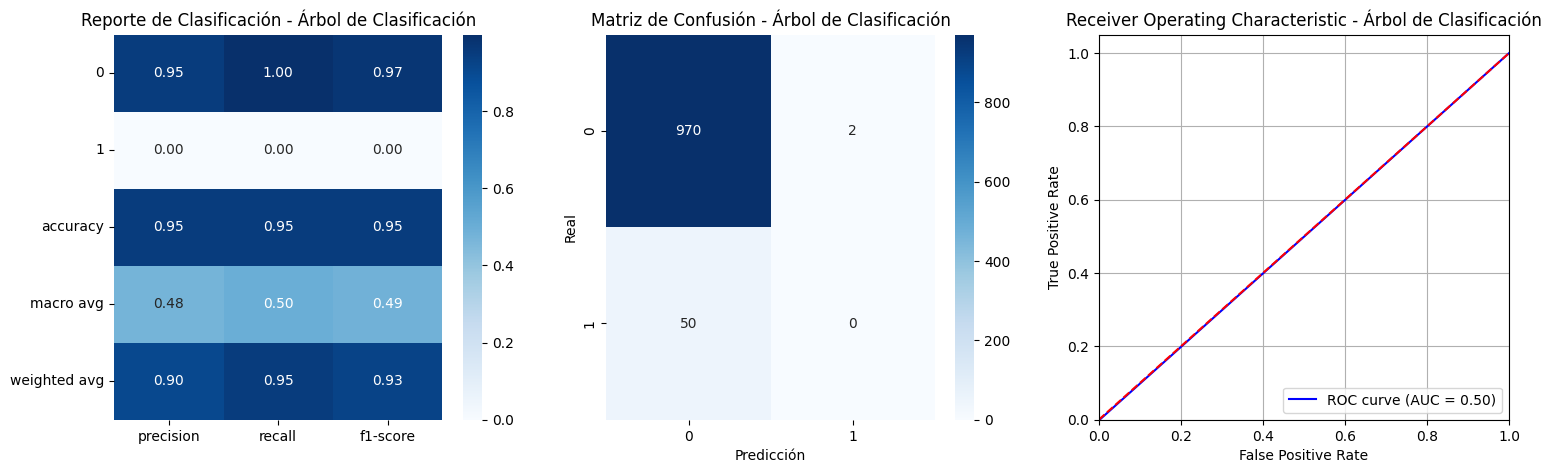

In [61]:
arbol_entropia = ArbolClasificacion(max_depth=3, criterio='entropia')
arbol_entropia.fit(X_train, y_train)
y_pred_entropia = arbol_entropia.predict(X_test)

mostrar_resultados(y_test, y_pred_entropia, "Árbol de Clasificación")

El resultado muestra una **accuracy** de 0.95, lo que se podría mal interpretar como un excelente desempeño. Pero al analizar los otros indicadores se observa que:
- Para la clase 1 (ACV), tanto la precisión como el recall son 0.00, es decir, el modelo no logra identificar ningún caso positivo correctamente.
- El **f1-score** para la clase 1 también es 0.00, lo que confirma que el modelo no es útil para detectar la ocurrencia de ACV.

Esto se debe al gran desbalance de clase que existe en el dataset. A continuación vamos a  aplicar una técnica de balanceo de clases para mejorar la sensibilidad hacia la clase minoritaria.

#### Oversampling

Utilizamos la clase RanmOverSampler de la librería imblearn para generar muestras sintéticas y disminuir los efectos del desbalance de clases en el entrenamiento del modelo y analizar los resultados.

Accuracy General: 0.7074363992172211


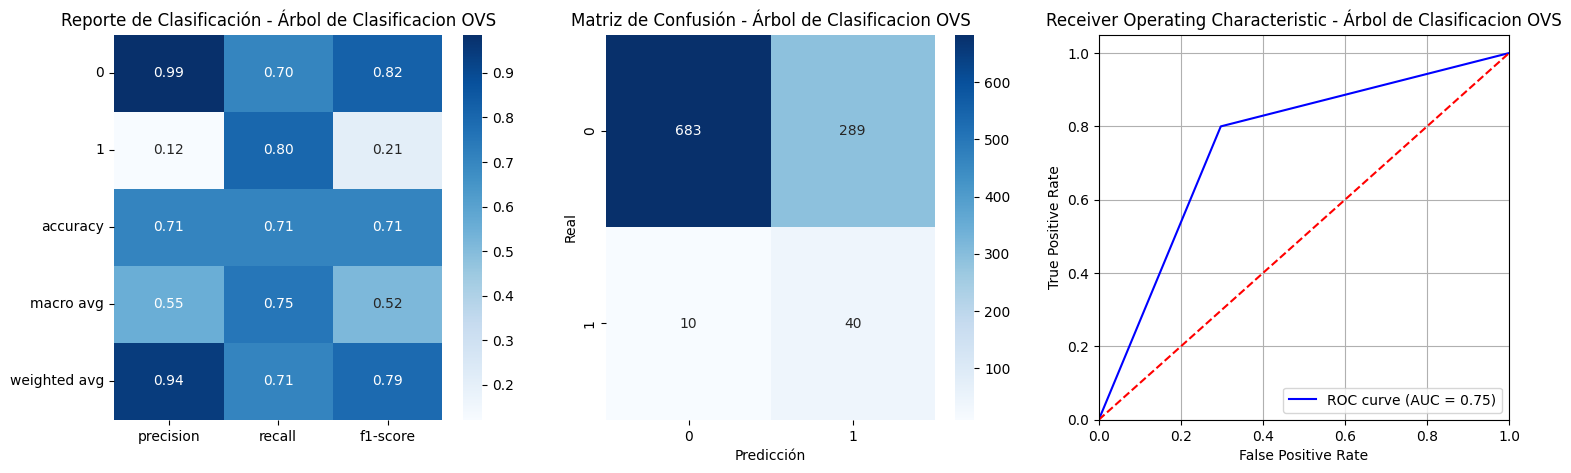

In [62]:
# Entrenar árbol sobre datos balanceados
arbol_entropia_ovs = ArbolClasificacion(max_depth=3, criterio='entropia')
arbol_entropia_ovs.fit(X_train_ovs, y_train_ovs)
y_pred_entropia_ovs = arbol_entropia_ovs.predict(X_test)

mostrar_resultados(y_test, y_pred_entropia_ovs,"Árbol de Clasificacion OVS")

Luego de aplicar oversampling para balancear las clases en el set de entrenamiento, el árbol de clasificación muestra un cambio significativo en su comportamiento:
- La **accuracy** general baja a 0.70, lo que puede parecer una disminución del desempeño, pero en realidad refleja que el modelo ahora está intentando identificar ambas clases.

- Vemos que se incrementan considerablemente los Falsos Positivos, de 2 a 235, pero si bien la precisión es (0.14) para la clase 1 (ACV), el recall es del 0.78, es decir que el modelo pudo identificar correctamente a tres cuartas partes de los casos positivos.

El modelo balanceado es mucho más útil desde el punto de vista de su finalidad de diagnostigo, ya que logra detectar la mayoría de los casos de ACV (alta sensibilidad), aunque a costa de aumentar los falsos positivos. En problemas donde la clase minoritaria es crítica (como la detección de ACV), suele ser preferible a un modelo que ignora completamente los casos positivos. El balanceo de los datos permitió que el árbol de clasificación aprenda patrones de la clase minoritaria y mejore su capacidad de detección, pero este comportamiento puede tratarse de un sobre-ajuste 


### Árbol de clasificación v2

Vamos a utlizar la clase DecisionTreeClassifier de scikit-learn para implementar un árbol de desición con hiperparámetros optimizados y compararlo con el que implementamos desde cero. Utilizamos Optuna para optimizar los hiperparámetros del modelo, considerando que maximice el f1-score y que pruebe 50 combinaciones. 
Definimos el modelo en un clase para aprovecha la reutilización 
Para tratar el desbalance de clase, establecemos el parrámetro class_weight='balanced' de la clase DecisionTreeClassifier, esto ajusta automáticamente los pesos de las clases inversamente proporcionales a su frecuencia en los datos. Esto hace que el modelo preste más atención a las clases minoritarias durante la construcción del árbol.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [95]:
def optimize_decision_tree(X, y, n_trials=50, n_jobs=-1, callbacks=None):
    def objective(trial):
        max_depth = trial.suggest_int("max_depth", 1, 30)
        criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
        min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
        min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)

        classifier = DecisionTreeClassifier(
            criterion=criterion,
            splitter='best',
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            class_weight="balanced",
            random_state=42
        )

        # Validación cruzada
        score = cross_val_score(classifier, X, y, cv=5, scoring='f1_macro', n_jobs=n_jobs)
        return score.mean()

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, callbacks=callbacks)

    print("Mejores parámetros:", study.best_params)

    best_model = DecisionTreeClassifier(**study.best_params, class_weight='balanced', random_state=42)
    best_model.fit(X, y)

    return best_model

best_dt = optimize_decision_tree(X_train, y_train)
best_dt

Mejores parámetros: {'max_depth': 21, 'criterion': 'gini', 'min_samples_split': 7, 'min_samples_leaf': 4}


,criterion,'gini'
,splitter,'best'
,max_depth,21
,min_samples_split,7
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


Accuracy General: 0.8708414872798435


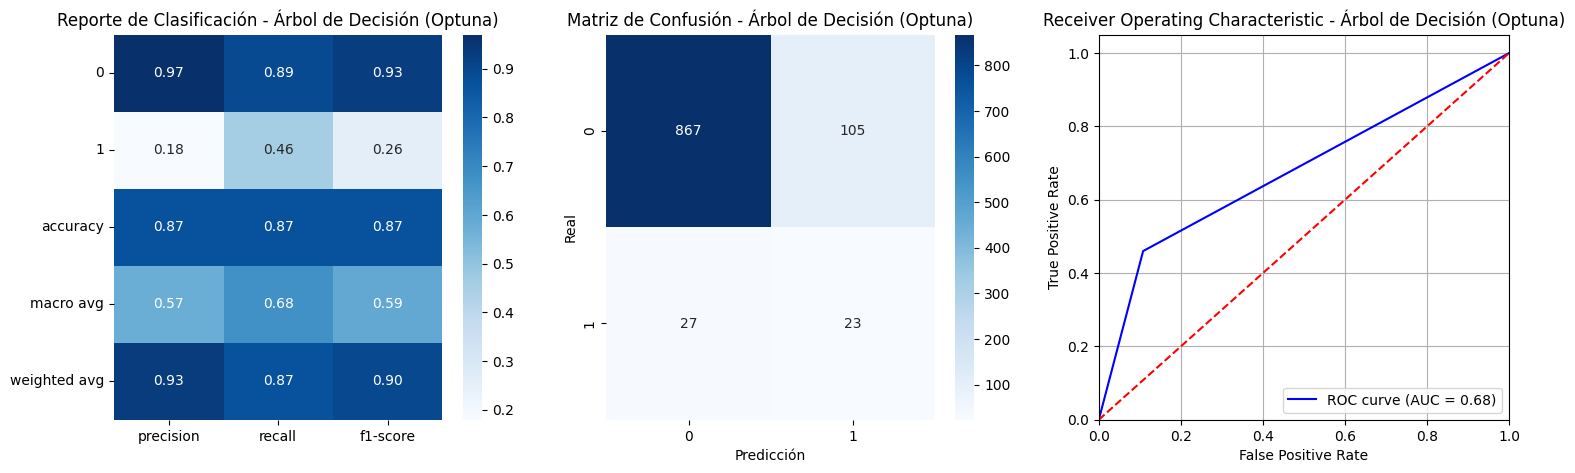

In [96]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_tree = best_dt.predict(X_test)

mostrar_resultados(y_test, y_pred_best_tree,"Árbol de Decisión (Optuna)")

Vemos que el resultado no es bueno, ocurre algo similiar qeu con el modelo anterior, no se logra identificar correctamente la clase minoritaria, debido al desbalance de clases

#### Árbol de clasificación v2 con SMOTE

Vamos probar el modelo usando el dataset al cual le aplicamos la técnica de sobremiestreo Synthetic Minority Over-sampling Technique (SMOTE) y ver si se mejoran los resulados.

In [97]:
#Obtenemos el modelo entrenado con los parámetros otimizados
best_dt_smote= optimize_decision_tree(X_train_ovs, y_train_ovs)
best_dt

Mejores parámetros: {'max_depth': 17, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 4}


,criterion,'gini'
,splitter,'best'
,max_depth,21
,min_samples_split,7
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


Accuracy General: 0.9227005870841487


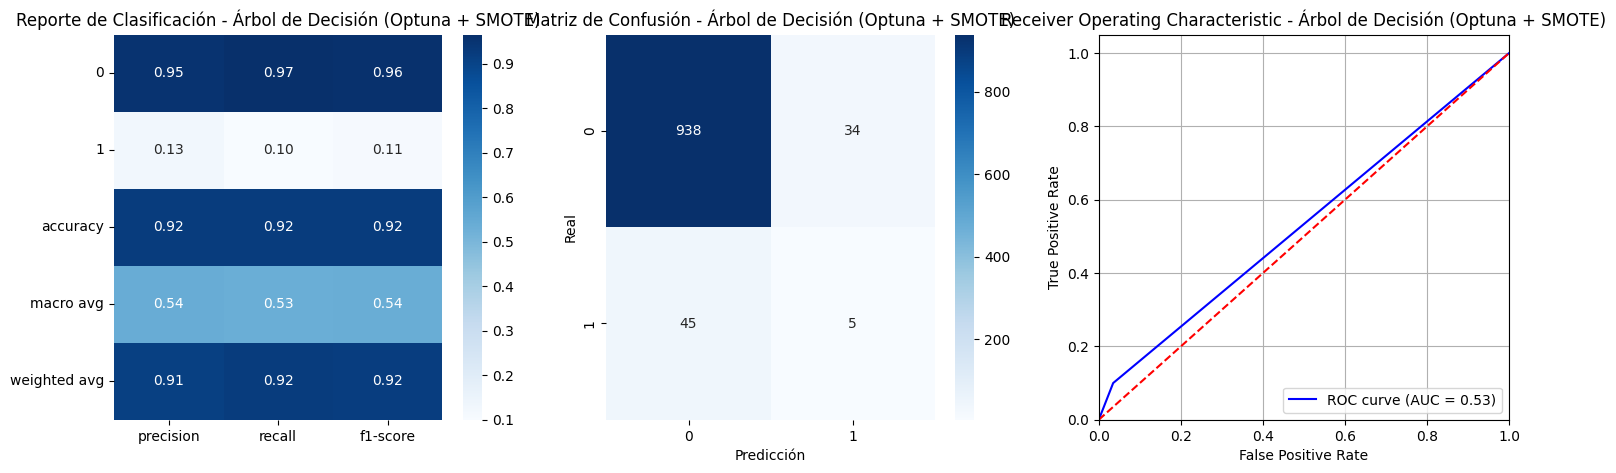

In [98]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_tree_smote = best_dt_smote.predict(X_test)

mostrar_resultados(y_test, y_pred_best_tree_smote,"Árbol de Decisión (Optuna + SMOTE)")

No se logran mejora utilizando el dataset con sobremuestras, sino alcontrario, disminullen los valores de precicion, recall y f1-score para la clase 1

### Suport vector machine

Vamos utilizar el modelo Suport Vector Machine que funciona bien en problemas con límites de desición complejo, pero requiere que se ajusten bien los parámetros C, kernel y gamma

- **C** regula la penalización por errores, valores pequeños producen márgenes más amplios pero pueden tolerar errores, mientras que valores grandes ajustan más los datos.

- **kernel** determina la función de transformación, la cual afecta la forma del límite de decisión.

- **gamma** influye en la influencia de puntos individuales en los datos en kernels como RBF.


Para determinar estos parámetros vamos a realizar una optimización de hiperparámetros como hicimos con el modelo anterior. También establecemos el parámetro **class_weight** en **balanced**.
  

In [72]:
def optimize_svc(X, y, n_trials=150, n_jobs=-1, warmup_steps=5):
    def objective(trial):
        params = {
            'C': trial.suggest_float('C', 0.001, 100, log=True),
            'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
            'class_weight': 'balanced',
            'random_state': 42
        }
        clf = SVC(**params)
        score = cross_val_score(clf, X, y, cv=3, scoring='f1_macro').mean()

        # Reportamos para el pruning
        trial.report(score, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return score

    # Estudio con pruner
    study = optuna.create_study(
        direction='maximize',
        pruner=MedianPruner(n_warmup_steps=warmup_steps)
    )
    study.optimize(objective, n_trials=n_trials, n_jobs=n_jobs)

    print("Mejores parámetros:", study.best_params)

    # Entrenamos el modelo con los mejores parámetros
    best_model = SVC(**study.best_params)
    best_model.fit(X, y)

    return best_model


opt_search = optimize_svc(X_train, y_train)
opt_search

[I 2025-08-23 18:20:22,286] A new study created in memory with name: no-name-59d24dfa-4565-4927-89fd-f110d1b18684
[I 2025-08-23 18:20:23,405] Trial 7 finished with value: 0.5365261164807915 and parameters: {'C': 12.649586413142531, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.5365261164807915.
[I 2025-08-23 18:20:23,646] Trial 3 finished with value: 0.525637784081458 and parameters: {'C': 0.0048064420068743684, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 7 with value: 0.5365261164807915.
[I 2025-08-23 18:20:23,922] Trial 2 finished with value: 0.5132374129264535 and parameters: {'C': 0.32323772658179983, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5365261164807915.
[I 2025-08-23 18:20:23,967] Trial 4 finished with value: 0.5114861146118849 and parameters: {'C': 15.560180013983178, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 7 with value: 0.5365261164807915.
[I 2025-08-23 18:20:24,070] Trial 1 finished with value: 0.52587006201486

Mejores parámetros: {'C': 0.034937376141073534, 'kernel': 'rbf', 'gamma': 'auto'}


,C,0.034937376141073534
,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Accuracy General: 0.9510763209393346


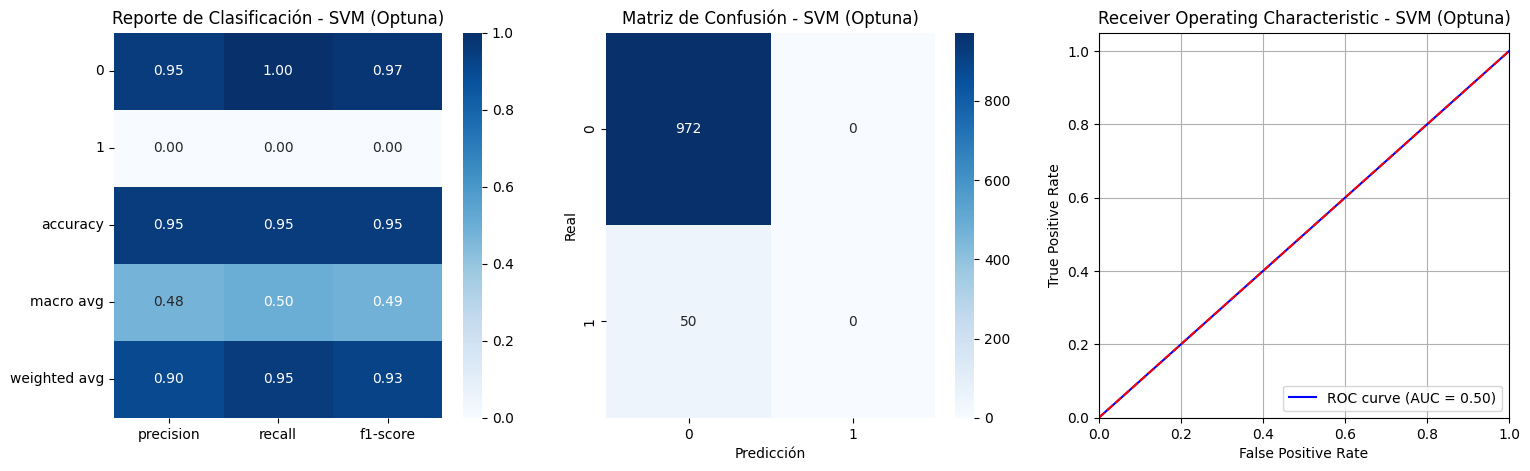

In [73]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_svm = opt_search.predict(X_test)

mostrar_resultados(y_test, y_pred_best_svm, "SVM (Optuna)")

El modelo predice todos lso valores de la misma forma, no pudo realizar una separación que le permita clasificar.

#### Suport vector machine con SMOTE

In [74]:
svm_smote_search = optimize_svc(X_train_res, y_train_res)
svm_smote_search

[I 2025-08-23 18:23:48,837] A new study created in memory with name: no-name-7f5f2043-de79-454f-ba3e-eb318c053cbd
[I 2025-08-23 18:23:52,236] Trial 1 finished with value: 0.9138383227654897 and parameters: {'C': 15.871567800446428, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 1 with value: 0.9138383227654897.
[I 2025-08-23 18:23:52,506] Trial 7 finished with value: 0.9227404126716309 and parameters: {'C': 43.7073318617151, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 7 with value: 0.9227404126716309.
[I 2025-08-23 18:23:53,139] Trial 4 finished with value: 0.7946128869181246 and parameters: {'C': 0.05763064048280007, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 7 with value: 0.9227404126716309.
[I 2025-08-23 18:23:53,258] Trial 5 finished with value: 0.7944756213738794 and parameters: {'C': 0.27093374357843897, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 7 with value: 0.9227404126716309.
[I 2025-08-23 18:23:53,369] Trial 6 finished with value: 0.796023981322088

Mejores parámetros: {'C': 99.58860848108878, 'kernel': 'rbf', 'gamma': 'auto'}


,C,99.58860848108878
,kernel,'rbf'
,degree,3
,gamma,'auto'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


Accuracy General: 0.8747553816046967


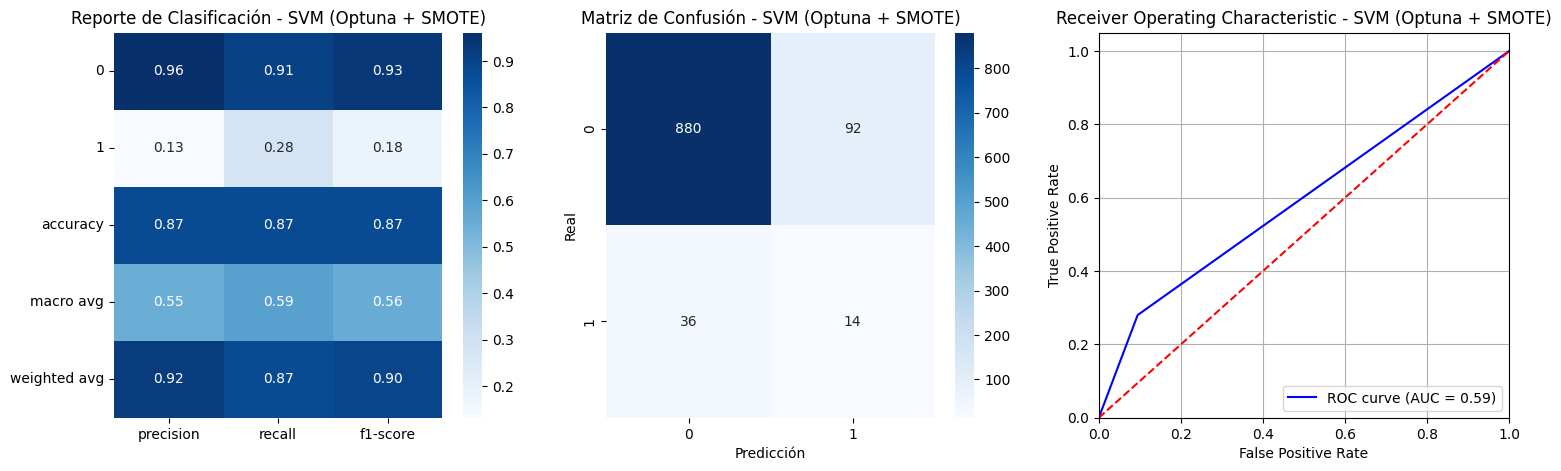

In [75]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_svm_smote = svm_smote_search.predict(X_test_scaled)

mostrar_resultados(y_test, y_pred_best_svm_smote,  "SVM (Optuna + SMOTE)")

### Random forest

Utilizamos Random Forest, es un ensamblador que se basa en la construcción de múltiples árboles de decisión durante el entrenamiento, en base a subconjuntos aleatoreos del dataset.
De la misma manera que en los anteriores, realizamos una optimización de hiperparámetros

In [83]:
def optimize_random_forest(X, y, n_trials=50, n_jobs=-1):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int("n_estimators", 50, 300),
            'max_depth': trial.suggest_int("max_depth", 2, 20),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 20),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            'criterion': trial.suggest_categorical("criterion", ["gini", "entropy"]),
            'class_weight': 'balanced',
            'random_state': 42,
            'n_jobs': n_jobs
        }
        clf = RandomForestClassifier(**params)
        score = cross_val_score(clf, X, y, cv=5, scoring="f1_macro", n_jobs=n_jobs).mean()

        # Reportamos para el pruning
        trial.report(score, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()

        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Mejores parámetros:", study.best_params)

    # Entrenar el modelo con los mejores parámetros
    best_rf = RandomForestClassifier(**study.best_params, class_weight='balanced', random_state=42, n_jobs=n_jobs)
    best_rf.fit(X, y)

    return best_rf

best_rf= optimize_random_forest(X_train, y_train)
best_rf

[I 2025-08-23 18:43:30,656] A new study created in memory with name: no-name-81276a42-8539-483a-be52-31e1bff39e65
[I 2025-08-23 18:43:31,326] Trial 0 finished with value: 0.5037149828768135 and parameters: {'n_estimators': 156, 'max_depth': 4, 'min_samples_split': 15, 'min_samples_leaf': 18, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.5037149828768135.
[I 2025-08-23 18:43:31,870] Trial 1 finished with value: 0.5630340034670415 and parameters: {'n_estimators': 117, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 19, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 1 with value: 0.5630340034670415.
[I 2025-08-23 18:43:32,514] Trial 2 finished with value: 0.5903724898233841 and parameters: {'n_estimators': 94, 'max_depth': 12, 'min_samples_split': 20, 'min_samples_leaf': 11, 'max_features': None, 'criterion': 'gini'}. Best is trial 2 with value: 0.5903724898233841.
[I 2025-08-23 18:43:33,756] Trial 3 finished with value: 0.557559180

Mejores parámetros: {'n_estimators': 217, 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'entropy'}


,n_estimators,217
,criterion,'entropy'
,max_depth,11
,min_samples_split,17
,min_samples_leaf,6
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Accuracy General: 0.9442270058708415


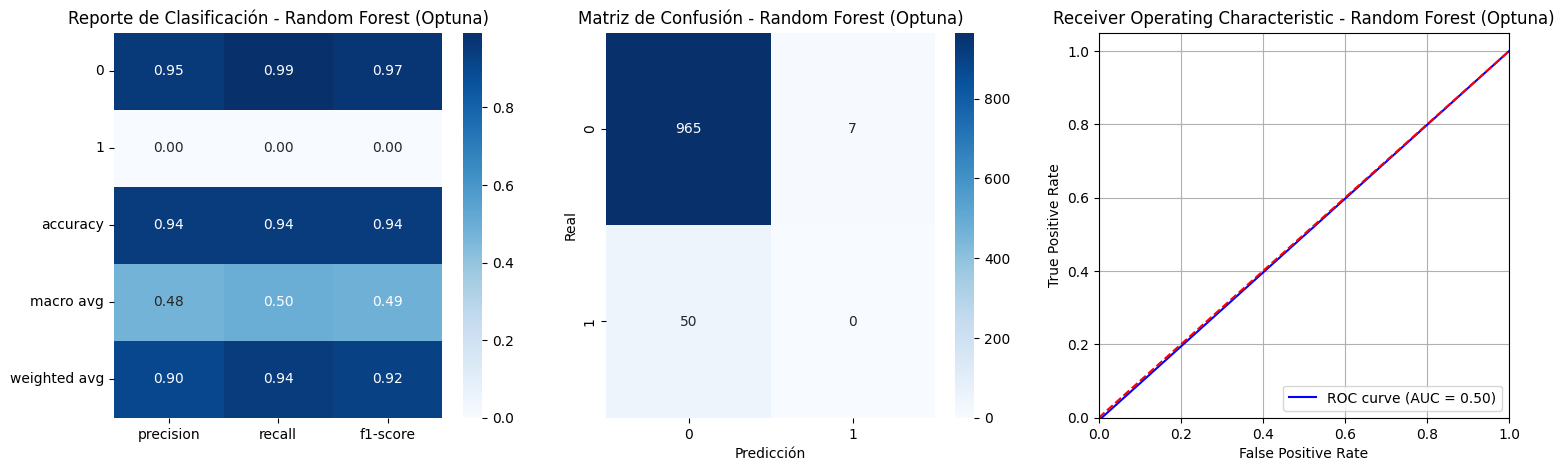

In [82]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_rdf = best_rf.predict(X_test)
mostrar_resultados(y_test, y_pred_best_rdf,  "Random Forest (Optuna)")


### XGBoost

In [87]:
def optimize_xgb(X, y, n_trials=50, n_jobs=-1):
    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'use_label_encoder': False,
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 15),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
            'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10)
        }
        clf = xgb.XGBClassifier(**params, random_state=42, n_jobs=n_jobs)
        score = cross_val_score(clf, X, y, cv=5, scoring='recall', n_jobs=n_jobs).mean()
        # Se puede agregar reporting y prune si se desea
        trial.report(score, step=0)
        if trial.should_prune():
            raise optuna.TrialPruned()
        return score

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Mejores parámetros:", study.best_params)

    best_xgb = xgb.XGBClassifier(**study.best_params, random_state=42, n_jobs=n_jobs, use_label_encoder=False, eval_metric='logloss')
    best_xgb.fit(X, y)

    return best_xgb

best_xgb = optimize_xgb(X_train, y_train)
best_xgb

[I 2025-08-23 18:46:56,770] A new study created in memory with name: no-name-c113780c-9c8d-4b33-ad88-5e2f53d256ef
[I 2025-08-23 18:46:57,004] Trial 0 finished with value: 0.21628205128205127 and parameters: {'n_estimators': 104, 'max_depth': 10, 'learning_rate': 0.020286064632209867, 'subsample': 0.6180485158751652, 'colsample_bytree': 0.8021409812235696, 'gamma': 2.286830318910539, 'reg_alpha': 0.49424165029764433, 'reg_lambda': 1.5654361630101143, 'scale_pos_weight': 9.571891523763748}. Best is trial 0 with value: 0.21628205128205127.
[I 2025-08-23 18:46:57,142] Trial 1 finished with value: 0.06500000000000002 and parameters: {'n_estimators': 254, 'max_depth': 3, 'learning_rate': 0.24742011862805183, 'subsample': 0.9739633425277061, 'colsample_bytree': 0.5533079815721966, 'gamma': 0.4119597250584772, 'reg_alpha': 3.9712183742559715, 'reg_lambda': 0.4822777689861302, 'scale_pos_weight': 2.2546690251886616}. Best is trial 0 with value: 0.21628205128205127.
[I 2025-08-23 18:46:57,330] T

Mejores parámetros: {'n_estimators': 233, 'max_depth': 2, 'learning_rate': 0.25638666344018324, 'subsample': 0.9989483757760322, 'colsample_bytree': 0.7385087255163291, 'gamma': 3.524430219372268, 'reg_alpha': 4.660063811534462, 'reg_lambda': 1.6049795626662475, 'scale_pos_weight': 8.25748744250656}


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7385087255163291
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Accuracy General: 0.8776908023483366


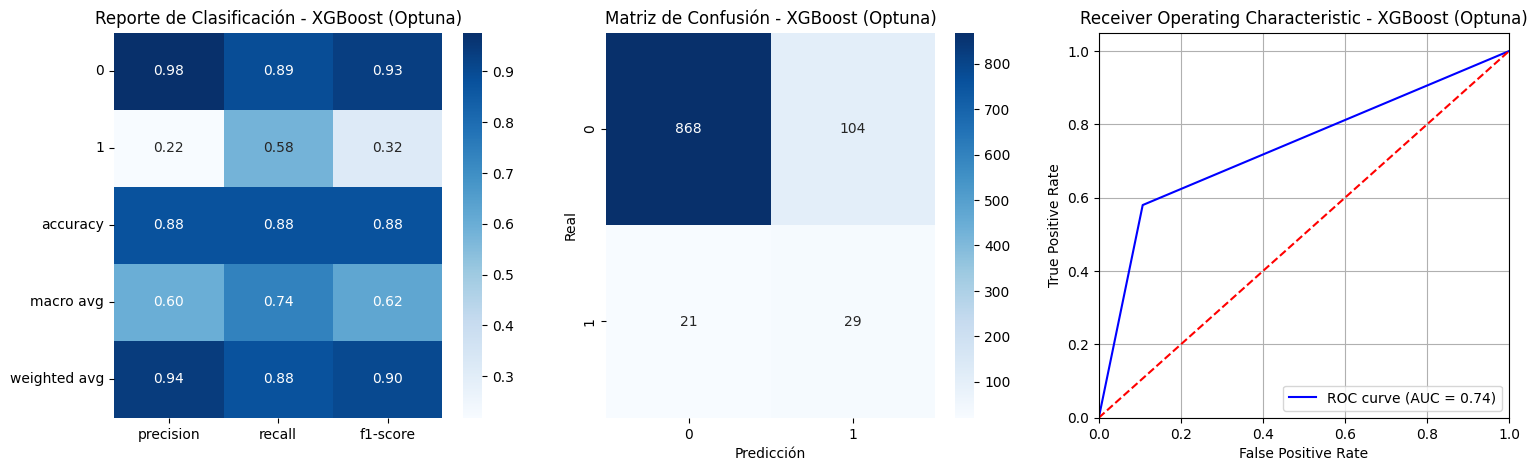

In [88]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_xgb = best_xgb.predict(X_test)

mostrar_resultados(y_test, y_pred_best_xgb,   "XGBoost (Optuna)")


#### XGBooston con SMOTE

In [89]:

best_xgb_smote= optimize_xgb(X_train_ovs, y_train_ovs)

[I 2025-08-23 18:47:55,503] A new study created in memory with name: no-name-bf0e9ab8-7094-407d-a604-bc00a1638577
[I 2025-08-23 18:47:55,923] Trial 0 finished with value: 0.9588662478122633 and parameters: {'n_estimators': 58, 'max_depth': 8, 'learning_rate': 0.031352138057346456, 'subsample': 0.5143500691775611, 'colsample_bytree': 0.9064056089245343, 'gamma': 3.4472048521990772, 'reg_alpha': 1.668634459164542, 'reg_lambda': 3.3339095990311285, 'scale_pos_weight': 2.388629288553135}. Best is trial 0 with value: 0.9588662478122633.
[I 2025-08-23 18:47:56,396] Trial 1 finished with value: 0.9573261473004404 and parameters: {'n_estimators': 172, 'max_depth': 7, 'learning_rate': 0.27417069499096697, 'subsample': 0.7963636824522653, 'colsample_bytree': 0.8514965680838189, 'gamma': 1.5821961751105285, 'reg_alpha': 0.24131156572881451, 'reg_lambda': 4.281816061224534, 'scale_pos_weight': 7.289302614606641}. Best is trial 0 with value: 0.9588662478122633.
[I 2025-08-23 18:47:56,830] Trial 2 f

Mejores parámetros: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.011156669728109803, 'subsample': 0.8330545593922796, 'colsample_bytree': 0.5931146835380139, 'gamma': 2.408802494152686, 'reg_alpha': 2.2706401115276753, 'reg_lambda': 4.868437890492017, 'scale_pos_weight': 7.536066562400651}


Accuracy General: 0.6105675146771037


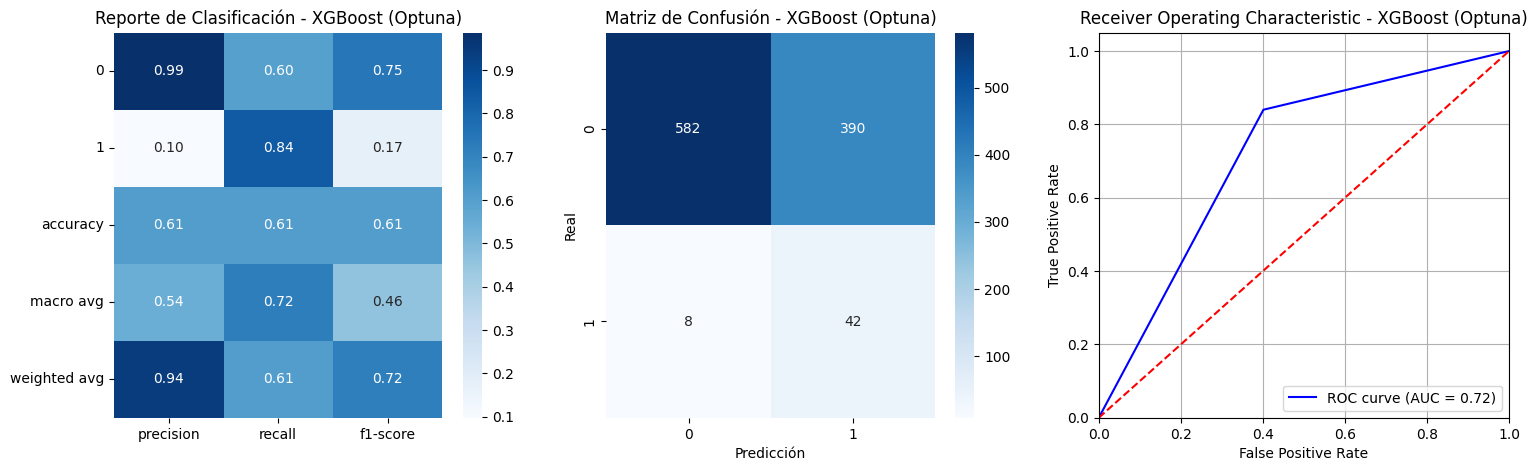

In [92]:
# Realizar predicción en el set de test con el mejor árbol de decisión
y_pred_best_xgb_smote = best_xgb_smote.predict(X_test)

mostrar_resultados(y_test, y_pred_best_xgb_smote,  "XGBoost (Optuna)")


### Ensamble de modelos

In [206]:
# Re-instanciar SVC con probability=True y entrenar

estimators = [
    ('tree', best_dt_smote),
    #('svm', svc_prob),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

soft_vot_clas = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
soft_vot_clas.fit(X_train, y_train)

y_pred_voting = soft_vot_clas.predict(X_test)
#y_pred_proba = soft_vot_clas.predict_proba(X_test)[:, 1]

# Mostrar métricas de desempeño
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_voting, digits=4))

Accuracy: 0.9080234833659491

Reporte de clasificación:
               precision    recall  f1-score   support

           0     0.9563    0.9465    0.9514       972
           1     0.1333    0.1600    0.1455        50

    accuracy                         0.9080      1022
   macro avg     0.5448    0.5533    0.5484      1022
weighted avg     0.9161    0.9080    0.9120      1022



## **Evaluación de Resultados**


In [99]:
modelos = {
    "Árbl de Clasificación Manual + SMOTE": y_pred_entropia_ovs,
    "Árbol de Decisión": y_pred_best_tree,
    "Árbol de Decisión + SMOTE": y_pred_best_tree_smote,
    "SVM": y_pred_best_svm,
    "SVM + SMOTE": y_pred_best_svm_smote,
    "Random Forest": y_pred_best_rdf,
    "XGBoost": y_pred_best_xgb,
    "XGBoost + SMOTE": y_pred_best_xgb_smote
}

resultados = []

for nombre, y_pred in modelos.items():
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    resultados.append({
        "Modelo": nombre,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    })

df_resultados = pd.DataFrame(resultados)
print("Resumen cuantitativo de métricas principales:")
print(df_resultados)

Resumen cuantitativo de métricas principales:
                                 Modelo  Accuracy  Precision  Recall  F1-score
0  Árbl de Clasificación Manual + SMOTE  0.707436   0.121581    0.80  0.211082
1                     Árbol de Decisión  0.870841   0.179688    0.46  0.258427
2             Árbol de Decisión + SMOTE  0.922701   0.128205    0.10  0.112360
3                                   SVM  0.951076   0.000000    0.00  0.000000
4                           SVM + SMOTE  0.874755   0.132075    0.28  0.179487
5                         Random Forest  0.944227   0.000000    0.00  0.000000
6                               XGBoost  0.877691   0.218045    0.58  0.316940
7                       XGBoost + SMOTE  0.610568   0.097222    0.84  0.174274


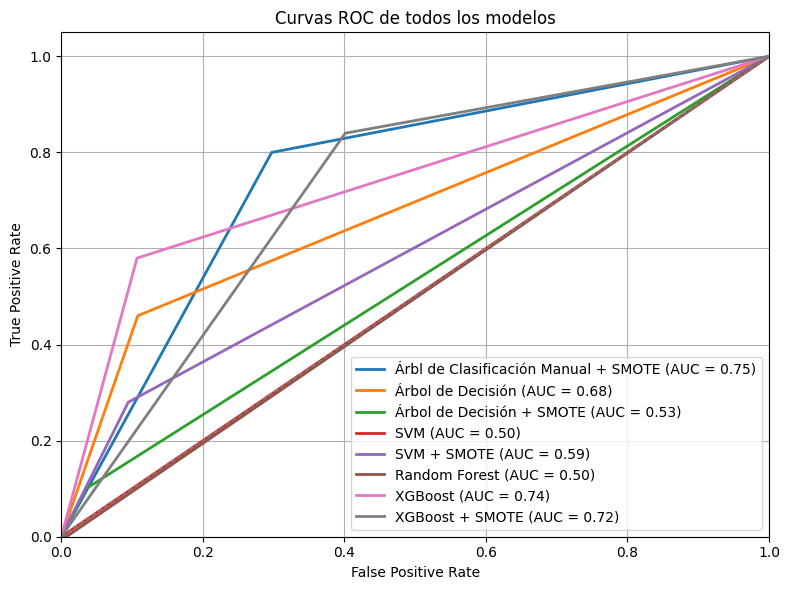

In [100]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for nombre, y_pred in modelos.items():
    # Para la curva ROC, necesitamos probabilidades o scores. Si solo tenemos clases, usamos como score la predicción binaria.
    # Si el modelo tiene predict_proba, se puede usar la probabilidad de la clase positiva.
    # Aquí, como tenemos arrays de clases, usamos directamente.
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC de todos los modelos')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

### Conclusión general

Los modelos sin balanceo tienden a ignorar la clase minoritaria (ACV), mostrando alta accuracy pero baja utilidad clínica. Los modelos con SMOTE mejoran la sensibilidad, aunque sacrifican precisión. En el contexto de detección de ACV, es preferible un modelo con alto recall para no omitir casos positivos, aunque implique más falsos positivos.